In [1]:
using Plots, StatsPlots
include("src/SFGP_classification-learnable.jl")
using Flux
using StatsBase
using CSV, DataFrames

In [2]:
df = Matrix(CSV.File("./data/banana.csv") |> DataFrame)[:,1:3]
X = transpose(df)[1:2,:]
y = (transpose(df)[3:3,:] .+ 1) ./2

1×5300 Matrix{Float64}:
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  …  1.0  1.0  1.0  1.0  1.0  0.0  1.0

In [3]:
function observed(mm::SFGP,m,s)
    probs = getProbs(m,s,mm.lower,mm.upper)[:]
    vals = (mm.vals)[:]
    
    dist = DiscreteNonParametric(σ.(vals),probs)
    
    mm = mean(dist)
    ss = std(dist)
    lower = quantile(dist,0.05)
    upper = quantile(dist,0.95)
    
    return mm,ss,lower,upper,dist
end

observed (generic function with 1 method)

3151.274967886493
2308.6298543373837
2011.545782333835
1799.5931650008317
1683.3428763171007
1600.003886088573
1589.5287198457884
1606.7747841761452
1516.3245112624934
1580.8527103559372
1510.4289132541414
1510.6125673236675
1489.2843804157778
1474.176138603222


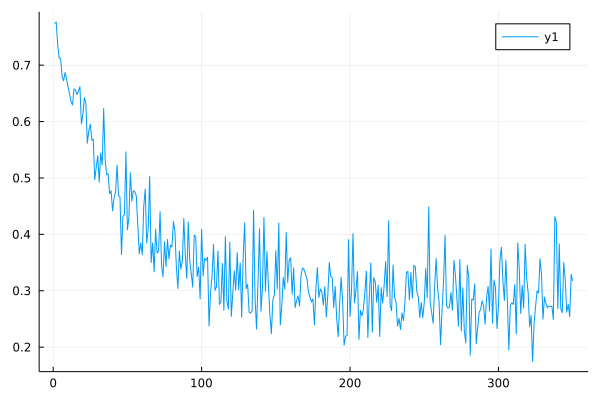

In [4]:
import Random
Random.seed!(1234)

sfgp = SFGP(SVGP(10,2),30,3)

x1g = collect(range(-4,4,length=50))
x2g = collect(range(-4,4,length=50))
x1grid = (x1g' .* ones(length(x2g)))[:] 
x2grid = (ones(length(x1g))' .* x2g)[:]
Xgrid = Matrix(transpose(hcat(x1grid,x2grid)))

params = Flux.params(sfgp)
opt = ADAM(0.05)


losses = []


for i in 1:350
    grads = Zygote.gradient(() -> sample_elbo(sfgp,X,y),params)
    Flux.Optimise.update!(opt,params,grads)
    push!(losses,sample_elbo(sfgp,X,y))
    
    if i%25==0
        println(elbo(sfgp,X,y))
    end
end

plot(losses)

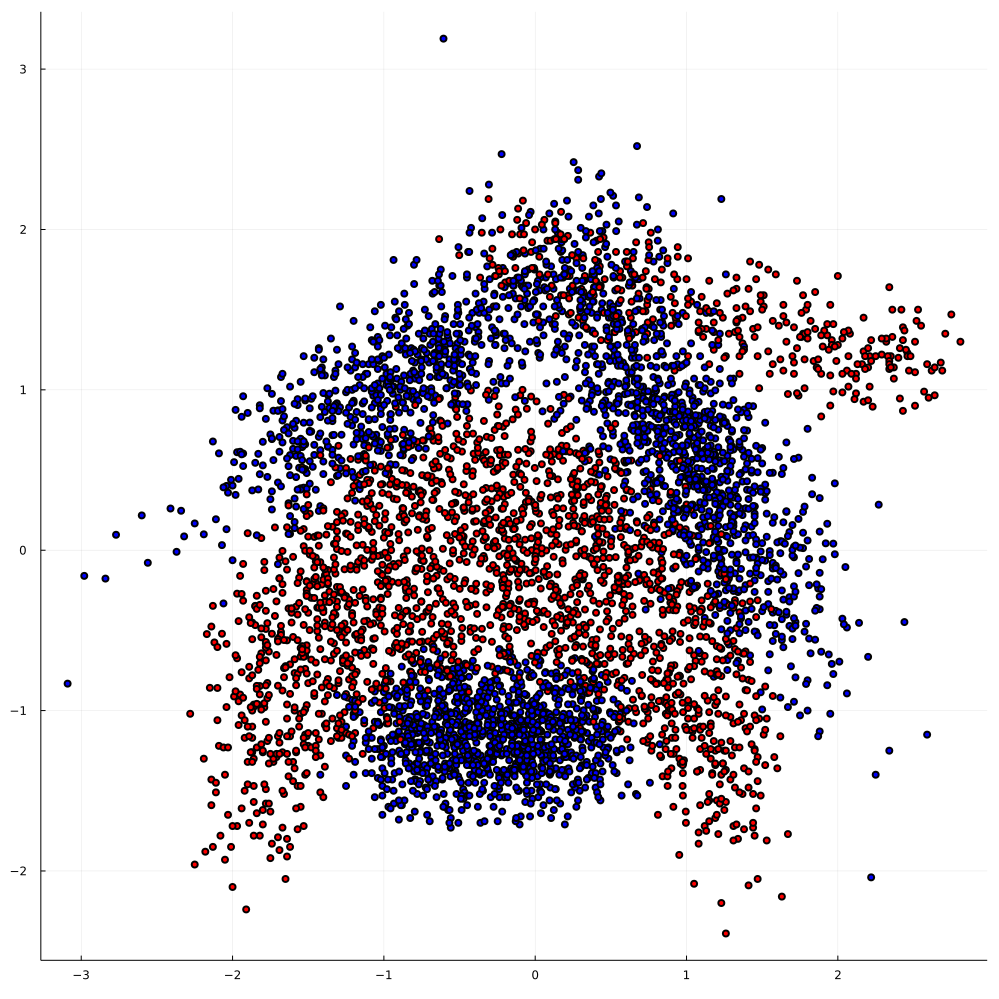

In [5]:
scatter(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none, c = :bwr, size = (1000,1000), fmt=:png)

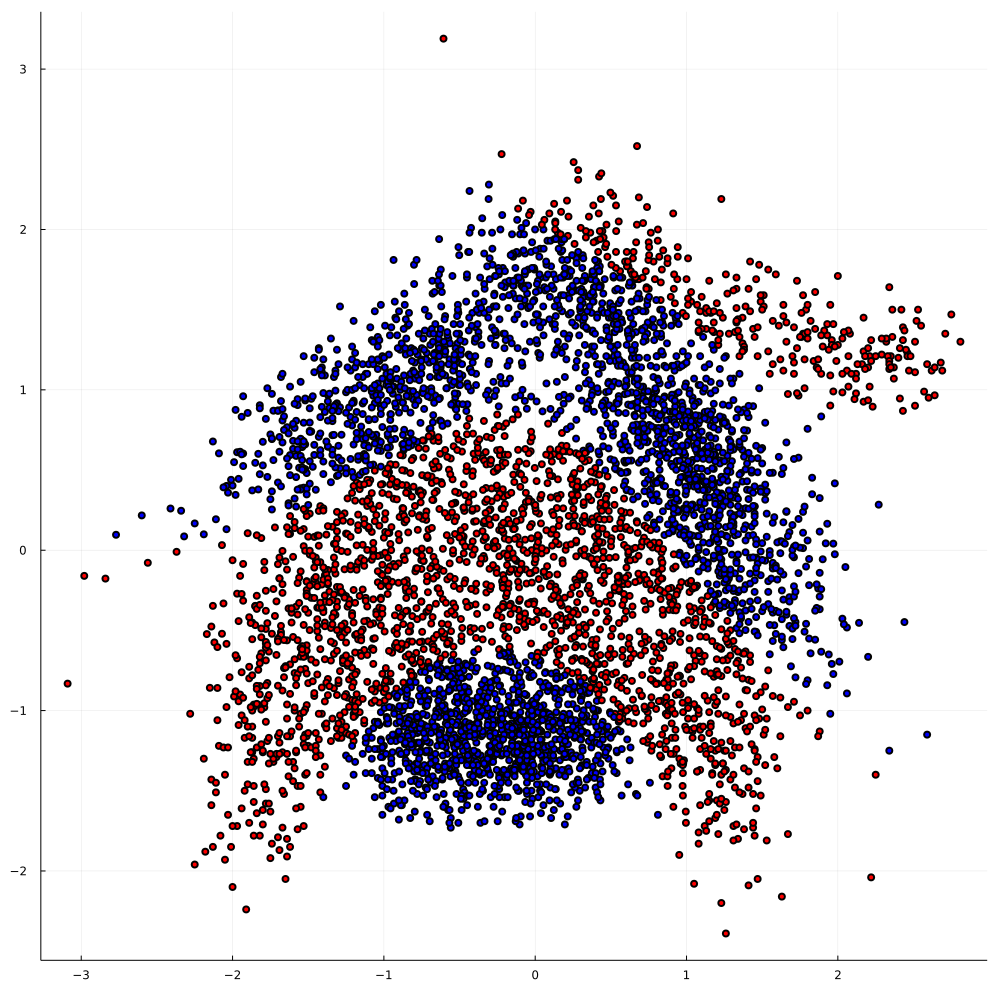

In [6]:
m,S = sfgp.gp(X)
s = sqrt.(diag(S))
scatter(X[1,:],X[2,:], zcolor = Int.(round.([observed(sfgp,z[1],z[2])[1] for z in zip(m[:],s[:])])), legend=:none,
c = :bwr, size=(1000,1000), fmt=:png)

In [7]:
function getval(x,y,val=1)
    
    m,S = sfgp.gp([x,y][:,:])
    s = sqrt.(S)
    return observed(sfgp,m[1],s[1])[val]
    
end

getval (generic function with 2 methods)

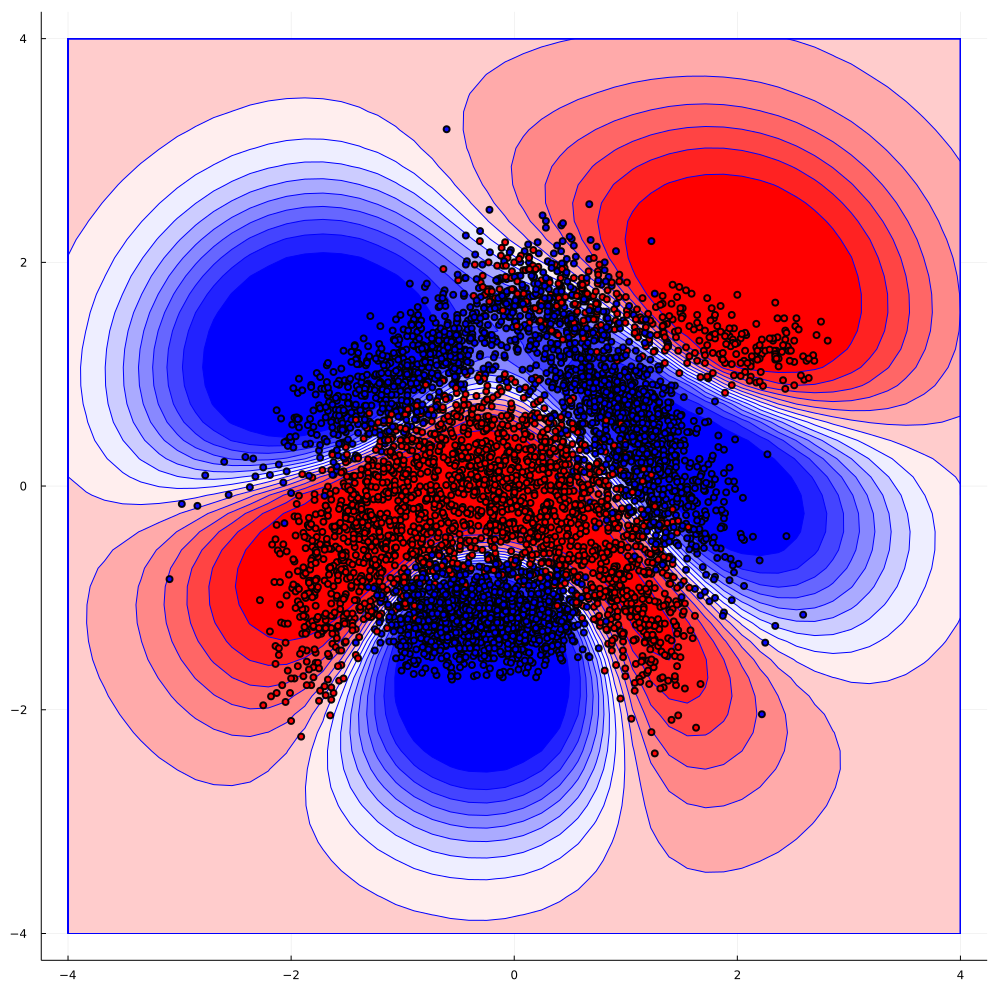

In [8]:
contourf(x1g,x2g, (x,y)->(getval(x,y,1)),c=:bwr,size=(1000,1000),colorbar=:none)
Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 3.5, alpha=0.95, c = :bwr, fmt=:png)

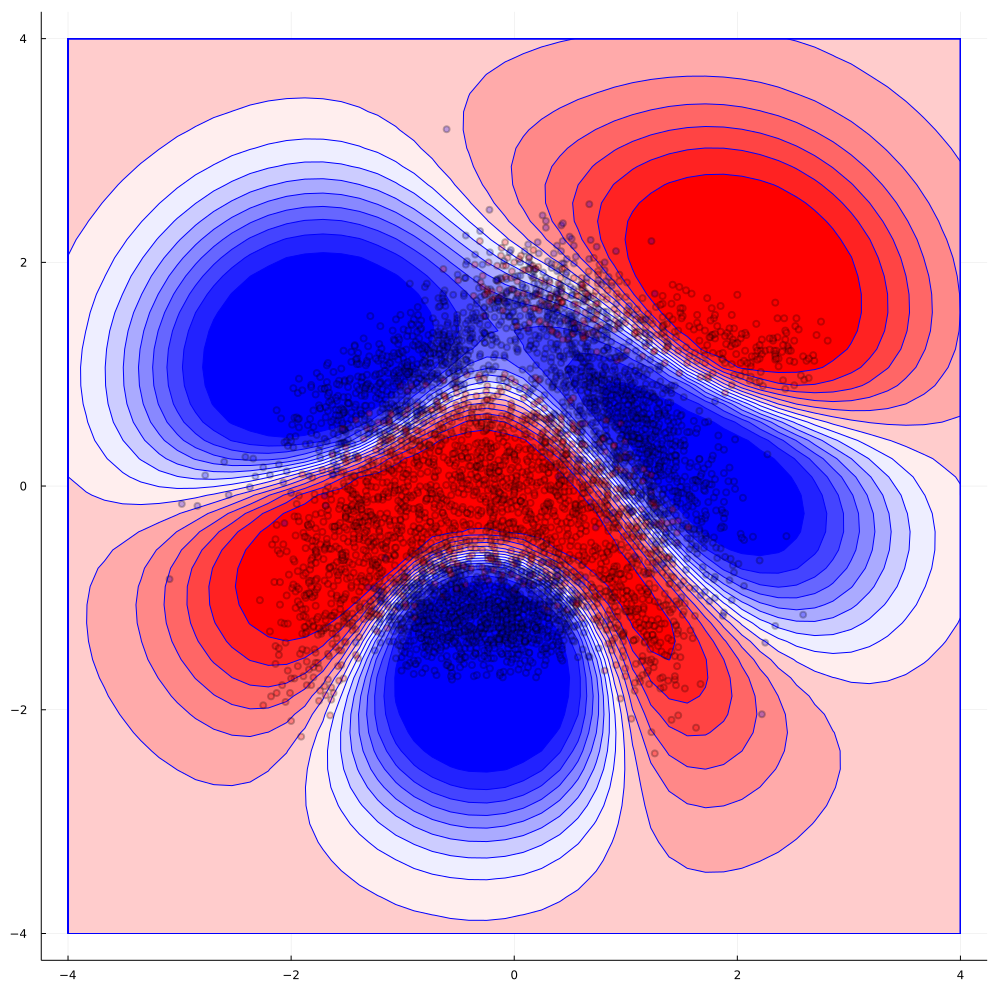

In [9]:
contourf(x1g,x2g, (x,y)->(getval(x,y,1)),c=:bwr,size=(1000,1000),colorbar=:none)
Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 3.5, alpha=0.25, c = :bwr, fmt=:png)

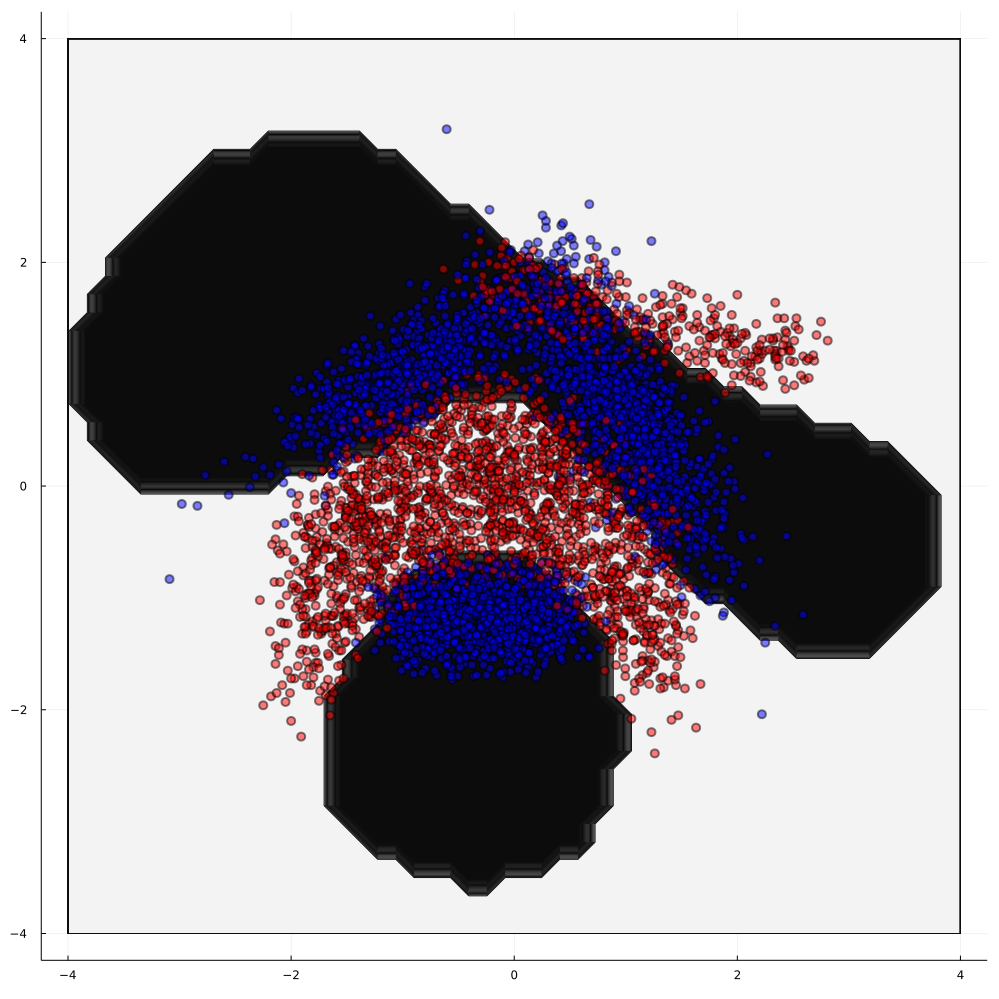

In [10]:
contourf(x1g,x2g, (x,y)->round(getval(x,y,1)),size = (1000,1000), colorbar = :none, c = :grays)

Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 5, alpha=0.5, c=:bwr, fmt = :png)

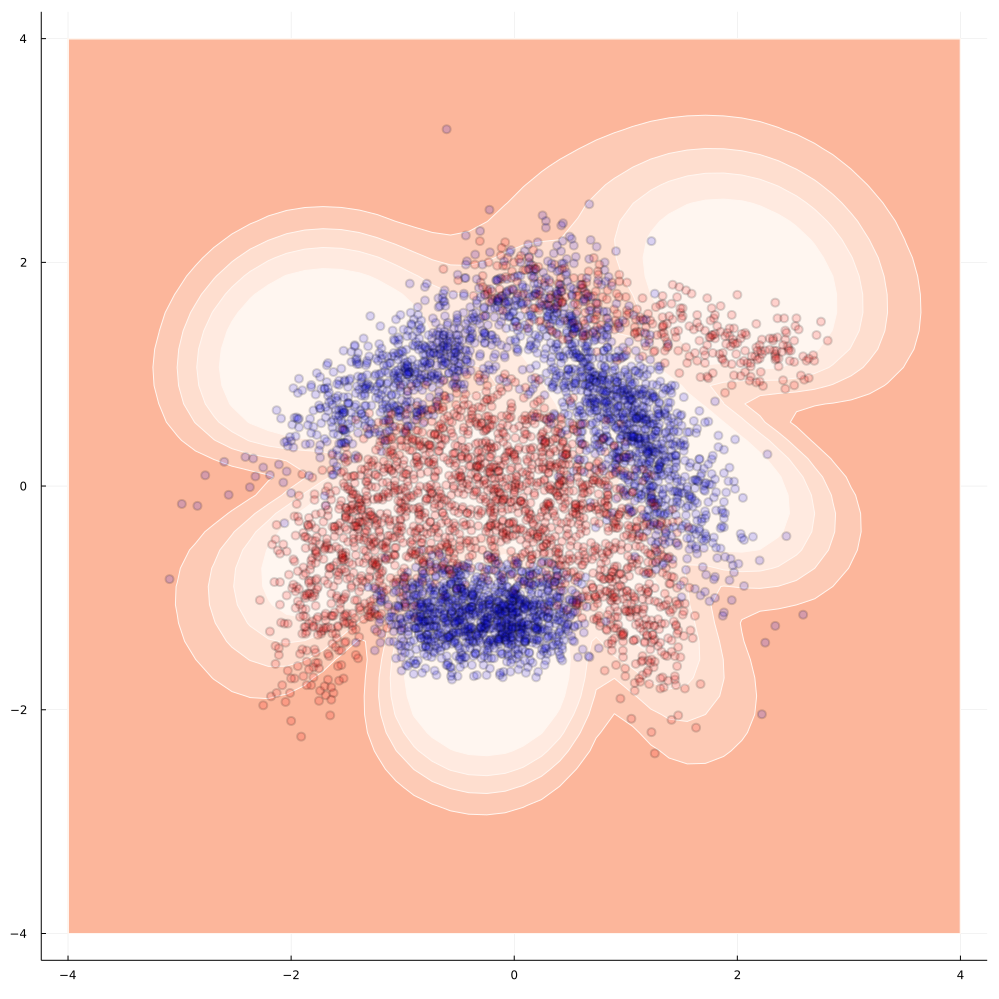

In [11]:
Plots.contourf(x1g,x2g, (x,y)->(getval(x,y,2)),size = (1000,1000), colorbar = :none, c = :Reds_9)

Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 5, alpha = 0.15, c = :bwr, fmt = :png)

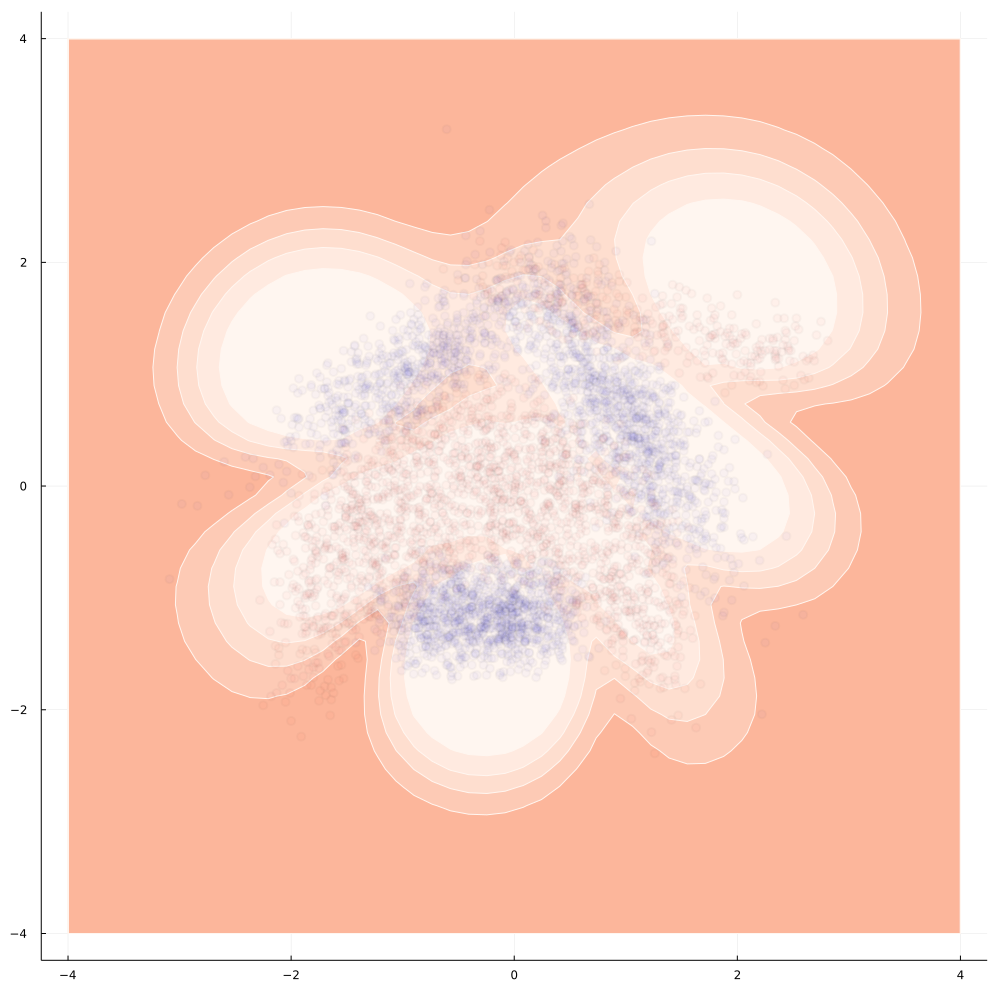

In [12]:
Plots.contourf(x1g,x2g, (x,y)->(getval(x,y,2)),size = (1000,1000), colorbar = :none, c = :Reds_9)
Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 5, alpha = 0.025, c = :bwr, fmt = :png)

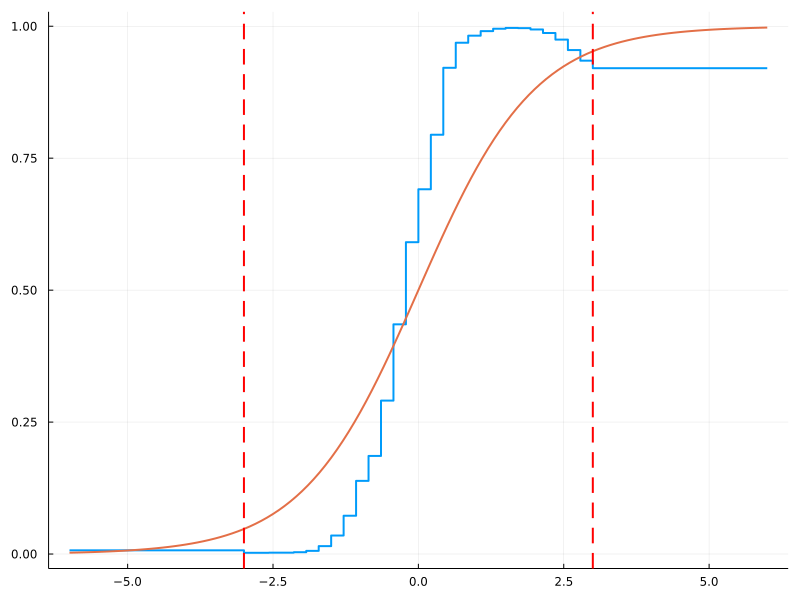

In [13]:
plot(vcat(-6,sfgp.upper[1:end-1],6),σ.(vcat(sfgp.vals[1],sfgp.vals)),legend=:none, linetype=:steppre,size=(800,600),lw=2,fmt=:png)

plot!(collect(-6:0.1:6),σ.(collect(-6:0.1:6)),lw=2)
vline!([-3,3],color=:red,s=:dash,lw=2)

In [14]:
sfgp.upper

30×1 Matrix{Float64}:
 -3.0
 -2.7857142857142856
 -2.5714285714285716
 -2.357142857142857
 -2.142857142857143
 -1.9285714285714286
 -1.7142857142857142
 -1.5
 -1.2857142857142858
 -1.0714285714285714
 -0.8571428571428571
 -0.6428571428571429
 -0.42857142857142855
  ⋮
  0.8571428571428571
  1.0714285714285714
  1.2857142857142858
  1.5
  1.7142857142857142
  1.9285714285714286
  2.142857142857143
  2.357142857142857
  2.5714285714285716
  2.7857142857142856
  3.0
  1.0e10

In [15]:
σ.(sfgp.vals)

30-element Vector{Float64}:
 0.007006250755880773
 0.002341115448251059
 0.0023404074441617847
 0.002487112702901356
 0.002580035708646049
 0.0033801000377328178
 0.005975364659530429
 0.0149204242638509
 0.03505035313382581
 0.07253360073726149
 0.13856583830256636
 0.18582745728818942
 0.29062967270595735
 ⋮
 0.9687538747563457
 0.9821246760220478
 0.9907906136354129
 0.9953558327994294
 0.9968830425917973
 0.9964242235407827
 0.9939680864048624
 0.9872271061106573
 0.974730841789328
 0.9548700780357641
 0.9347832331269295
 0.9205121669757963